__2 experiment:__

$f(x)=exp(-x_1^2 - 0.5(x_2 - 1)x_2)$

$\hat{f}(x)$ - linear combination of Chebyshev polynomials/their miltiplication

points from uniform distribution from $[-2, 2] \times [-2, 2]$

Рассмотрим задачу аппроксимации функции $f(x)=exp(-x_1^2 - 0.5(x_2 - 1)x_2)$ полиномами Чебышева - полиномами вида: 
$T_0(x) = 1$, $T_1(x)=x$, $T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$ на $[-2, 2]^2$.

В классическом подходе: $f(x) \approx \hat{f}(x) = \sum_{i=1}^{M}{\alpha_{i}P_i(x)}$, где $\alpha_i$ могут быть найдены с помощью метода наименьших квадратов, который будет уменьшать норму остатков в выбранных точках множества $[-2, 2]^2$: $\sum{(f(x_i) - \hat{f}(x_i))^2} \to \min$.

Рассмотрим другой подход, использующий информацию о градиентах функции f.
Будем решать следующую задачу: $A\alpha = F$, где $\alpha = (\alpha_1, \alpha_2, \dots, \alpha_M)^T$ - вектор весов, упомянутых выше. Назовем множество выбранных точек из $[-2, 2]^2$ множеством $G=\{(g_{1,1}, g_{1,2}), (g_{2,1}, g_{2,2}), \dots, (g_{k,1}, g_{k,2})\}$. Тогда $F$ - вектор размерности $3k$, состоящий из значений функции $F$ в точках множества $G$ и градиентов в этих же точках сначала по $x_1$, потом по $x_2$:

$$
F = \left(f(g_{1,1}, g_{1,2}), f(g_{2,1}, g_{2,2}), \dots, f(g_{k,1}, g_{k,2}), d_{x1}f(g_{1,1}, g_{1,2}),
d_{x1}f(g_{2,1}, g_{2,2}), \dots, d_{x1}f(g_{k,1}, g_{k,2}), d_{x2}f(g_{1,1}, g_{1,2}),
 \dots, d_{x2}f(g_{k,1}, g_{k,2})
\right).
$$

А матрица $A$ имеет вид:

$$
A=
\begin{bmatrix}
    P_{1}(g_{1,1}, g_{1,2}) & P_{2}(g_{1,1}, g_{1,2}) & \dots  & P_{M}(g_{1,1}, g_{1,2}) \\
    P_{1}(g_{2,1}, g_{2,2}) & P_{2}(g_{2,1}, g_{2,2}) & \dots  & P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    P_{1}(g_{k,1}, g_{k,2}) & P_{2}(g_{k,1}, g_{k,2}) & \dots  & P_{M}(g_{k,1}, g_{k,2}) \\
    d_{x_1}P_{1}(g_{1,1}, g_{1,2}) & d_{x_1}P_{2}(g_{1,1}, g_{1,2}) & \dots  & d_{x_1}P_{M}(g_{1,1}, g_{1,2}) \\
    d_{x_1}P_{1}(g_{2,1}, g_{2,2}) & d_{x_1}P_{2}(g_{2,1}, g_{2,2}) & \dots  & d_{x_1}P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    d_{x_1}P_{1}(g_{k,1}, g_{k,2}) & d_{x_1}P_{2}(g_{k,1}, g_{k,2}) & \dots  & d_{x_1}P_{M}(g_{k,1}, g_{k,2}) \\
    d_{x_2}P_{1}(g_{1,1}, g_{1,2}) & d_{x_2}P_{2}(g_{1,1}, g_{1,2}) & \dots  & d_{x_2}P_{M}(g_{1,1}, g_{1,2}) \\
    d_{x_2}P_{1}(g_{2,1}, g_{2,2}) & d_{x_2}P_{2}(g_{2,1}, g_{2,2}) & \dots  & d_{x_2}P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    d_{x_2}P_{1}(g_{k,1}, g_{k,2}) & d_{x_2}P_{2}(g_{k,1}, g_{k,2}) & \dots  & d_{x_2}P_{M}(g_{k,1}, g_{k,2}) \\
\end{bmatrix}
$$

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import accuracy_score

In [3]:
import types
import functools
def copy_func(f):
    g = types.FunctionType(f.__code__, f.__globals__, name=f.__name__,
                           argdefs=f.__defaults__,
                           closure=f.__closure__)
    g = functools.update_wrapper(g, f)
    g.__kwdefaults__ = f.__kwdefaults__
    return g

def f(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2)

def d_f1(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2) * (-2*x1)

def d_f2(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2) * (-x2 + 0.5)

def P(x, n):
#     print(n)
    if n == 0:
        return 1
    if n == 1:
        return x
    return 2 * x * P(x, n - 1) - P(x, n - 2)

def P_wrapper(n, is_first_arg, func):
    t = copy_func(func)
    t.__defaults__ = (n,)
    if is_first_arg:
        return lambda x1, x2: t(x1)
    return lambda x1, x2: t(x2)

def P_wrapper_comb(n1, n2, func1, func2):
    t1 = copy_func(func1)
    t1.__defaults__ = (n1,)
    t2 = copy_func(func2)
    t2.__defaults__ = (n2,)
    return lambda x1, x2: t1(x1) * t2(x2)

def d_P(x, n):
    if n == 0:
        return 0
    if n == 1:
        return 1
    return 2 * x * d_P(x, n - 1) + 2 * P(x, n - 1) - d_P(x, n - 2)

In [4]:
def build_P_polynoms():
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(P_wrapper(deg, True, P))
        t = P_polynoms[0]
        P_polynoms.append(P_wrapper(deg, False, P))
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(P_wrapper_comb(first_monom_deg, deg - first_monom_deg, P, P))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(P_wrapper_comb(deg - first_monom_deg, first_monom_deg, P, P))
    return P_polynoms

def build_d1_P_polynoms():
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(P_wrapper(deg, True, d_P))
        P_polynoms.append(lambda x1, x2: 0)
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(P_wrapper_comb(first_monom_deg, deg - first_monom_deg, d_P, P))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(P_wrapper_comb(deg - first_monom_deg, first_monom_deg, d_P, P))
    return P_polynoms

def build_d2_P_polynoms():
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(lambda x1, x2: 0)
        P_polynoms.append(P_wrapper(deg, False, d_P))
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(P_wrapper_comb(first_monom_deg, deg - first_monom_deg, P, d_P))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(P_wrapper_comb(deg - first_monom_deg, first_monom_deg, P, d_P))
    return P_polynoms

In [5]:
P_polynoms = build_P_polynoms()
d1_P_polynoms = build_d1_P_polynoms()
d2_P_polynoms = build_d2_P_polynoms()

In [6]:
P_polynoms[0](99, 100)

1

In [13]:
def get_mean_l2_norm(size=50, p_count=5):
    SIZE = size
    P_COUNT = p_count
    
    mean_with_grad = []
    mean_no_grad = []
    for i in range(50):
        points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        x1s = points[:,0]
        x2s = points[:,1]
        F_with_grad = np.array(
            [f(p[0], p[1]) for p in points] + \
            [d_f1(p[0], p[1]) for p in points] + \
            [d_f2(p[0], p[1]) for p in points])
        F_no_grad = np.array([f(p[0], p[1]) for p in points])
        A_with_grad = np.array(
            [[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points] + \
            [[d1_P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points] + \
            [[d2_P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points])
        A_no_grad = np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points])
        r_with_grad = LinearRegression()
        r_no_grad = LinearRegression()
        r_with_grad.fit(A_with_grad, F_with_grad)
        r_no_grad.fit(A_no_grad, F_no_grad)
        def f_model_with_grad(x1, x2):
            return np.sum([r_with_grad.coef_[i] * P_polynoms[i](x1, x2) for i in range(P_COUNT)]) + r_with_grad.intercept_

        def f_model_no_grad(x1, x2):
            return np.sum([r_no_grad.coef_[i] * P_polynoms[i](x1, x2) for i in range(P_COUNT)]) + r_no_grad.intercept_

        test_points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        test_x1s = points[:,0]
        test_x2s = points[:,1]
        mean_with_grad.append(
            np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - np.array([f_model_with_grad(p[0], p[1]) for p in test_points])))
        mean_no_grad.append(
            np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - np.array([f_model_no_grad(p[0], p[1]) for p in test_points])))
        
#         print(mean_no_grad[-1], end=' ')
#         print(np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - r_no_grad.predict(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in test_points]))), end=' - ')
#         print(mean_with_grad[-1], end=' ')
#         print(np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - r_with_grad.predict(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in test_points]))))
    
        
    return np.mean(mean_with_grad), np.mean(mean_no_grad), np.var(mean_with_grad), np.var(mean_no_grad)

In [10]:
get_mean_l2_norm(size=200, p_count=50)

(0.7660663531710603,
 1.7324333532910299,
 0.01608289248537632,
 1.1575325511191776)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,

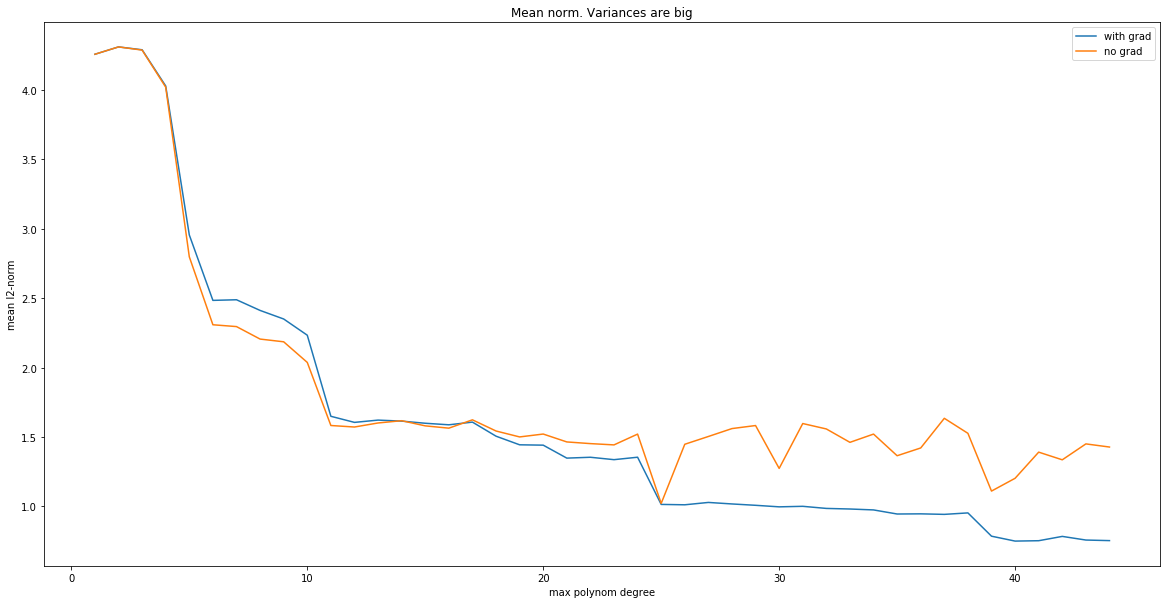

In [14]:
plt.figure(figsize=(20,10))
sample_size = 200
mean_with_grad_res = []
mean_no_grad_res = []
var_with_grad_res = []
var_no_grad_res = []
p_counts = np.arange(1, 45,1)
for p_count in p_counts:
    print(p_count, end=',')
    mean_with_grad, mean_no_grad, var_with_grad, var_no_grad = get_mean_l2_norm(sample_size, p_count)
    mean_with_grad_res.append(mean_with_grad)
    mean_no_grad_res.append(mean_no_grad)
    var_with_grad_res.append(var_with_grad)
    var_no_grad_res.append(var_no_grad)

plt.title('Mean norm. Variances are big')
plt.plot(p_counts, mean_with_grad_res, label='with grad')
plt.plot(p_counts, mean_no_grad_res, label='no grad')
plt.xlabel('max polynom degree')
plt.ylabel('mean l2-norm')
plt.legend()
plt.show()